# Домашнее задание № 8

## Задание 1 (4 балла) 

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  



Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [ ]:
import tensorflow as tf

In [ ]:
import os, re

In [ ]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

ROOT_DIR = '/content/drive' 
drive.mount(ROOT_DIR)

root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', 'rnn_ner')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/My Drive/rnn_ner/lenta_40k.csv.zip')

In [ ]:
data.head(5)

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


In [ ]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [ ]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [ ]:
len(vocab)

354611

In [ ]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [ ]:
len(filtered_vocab)

24091

In [ ]:
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
MAX_LEN = max(len(x) for x in X)

In [ ]:
MEAN_LEN = np.median([len(x) for x in X])

In [ ]:
MAX_LEN, MEAN_LEN

(1748, 170.0)

In [ ]:
MAX_LEN = int(MEAN_LEN + 30)

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [ ]:
X.shape

(44356, 200)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [ ]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
len(label2id)

19

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

# **GRU**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 30)           722790    
                                                                 
 gru (GRU)                   (None, 128)               61440     
                                                                 
 dense (Dense)               (None, 19)                2451      
                                                                 
Total params: 786,681
Trainable params: 786,681
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 123s 3s/step - loss: 2.5808 - f1: 0.0053 - rec@prec: 0.0000e+00 - val_loss: 2.3302 - val_f1: 0.0000e+00 - val_rec@prec: 4.5086e-04
Epoch 2/20
43/43 [==============================] - 117s 3s/step - loss: 2.2782 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2274 - val_f1: 0.0000e+00 - val_rec@prec: 0.0023
Epoch 3/20
43/43 [==============================] - 117s 3s/step - loss: 2.0957 - f1: 0.0015 - rec@prec: 0.0023 - val_loss: 2.0229 - val_f1: 0.0040 - val_rec@prec: 0.0054
Epoch 4/20
43/43 [==============================] - 116s 3s/step - loss: 1.8645 - f1: 0.0407 - rec@prec: 0.0106 - val_loss: 1.8793 - val_f1: 0.0890 - val_rec@prec: 0.0216
Epoch 5/20
43/43 [==============================] - 116s 3s/step - loss: 1.6668 - f1: 0.1651 - rec@prec: 0.0996 - val_loss: 1.7576 - val_f1: 0.1909 - val_rec@prec: 0.0848
Epoch 6/20
43/43 [==============================] - 121s 3s/step - loss: 1.4725 - f1: 0.3336 - rec@prec: 0.2196 - val_los

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


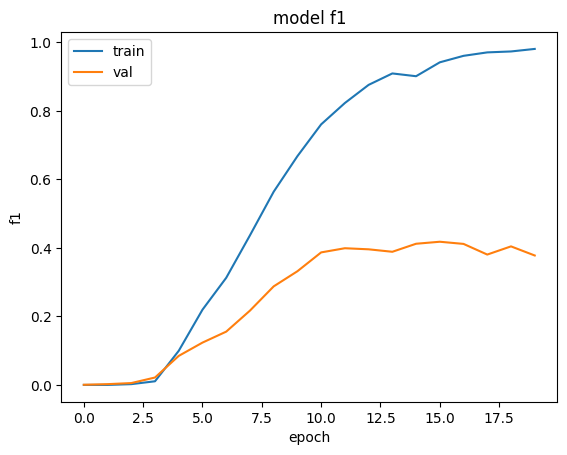

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **LSTM**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 30)           722790    
                                                                 
 lstm (LSTM)                 (None, 128)               81408     
                                                                 
 dense_1 (Dense)             (None, 19)                2451      
                                                                 
Total params: 806,649
Trainable params: 806,649
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 143s 3s/step - loss: 2.4695 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3189 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 139s 3s/step - loss: 2.3051 - f1: 0.0000e+00 - rec@prec: 1.1866e-04 - val_loss: 2.2793 - val_f1: 0.0000e+00 - val_rec@prec: 0.0054
Epoch 3/20
43/43 [==============================] - 138s 3s/step - loss: 2.1753 - f1: 0.0056 - rec@prec: 4.7463e-04 - val_loss: 2.0219 - val_f1: 0.0000e+00 - val_rec@prec: 0.0081
Epoch 4/20
43/43 [==============================] - 138s 3s/step - loss: 1.8464 - f1: 0.0884 - rec@prec: 0.0501 - val_loss: 1.7550 - val_f1: 0.1589 - val_rec@prec: 0.1208
Epoch 5/20
43/43 [==============================] - 140s 3s/step - loss: 1.5652 - f1: 0.2637 - rec@prec: 0.1663 - val_loss: 1.6769 - val_f1: 0.2900 - val_rec@prec: 0.0803
Epoch 6/20
43/43 [==============================] - 137s 3s/step - loss: 1.3644 - f1: 0.4611 - rec@prec: 0.27

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


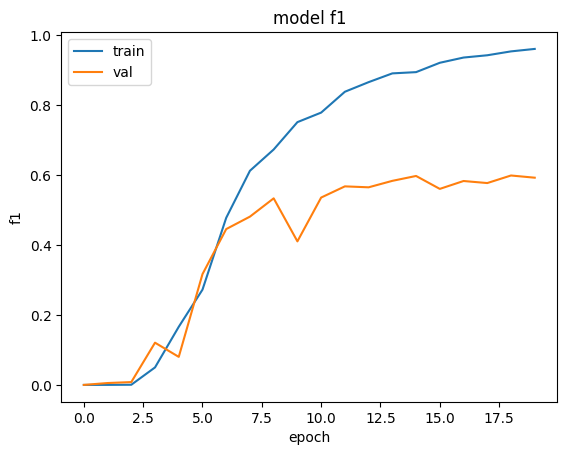

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **GRU**, **LSTM**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
lstm_2 = tf.keras.layers.GRU(128, return_sequences=False)(lstm_1)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 30)           722790    
                                                                 
 lstm_1 (LSTM)               (None, 200, 128)          81408     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 19)                1235      
                                                                 
Total params: 912,761
Trainable params: 912,761
Non-trainab

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 324s 7s/step - loss: 2.5029 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3278 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 308s 7s/step - loss: 2.2534 - f1: 8.8287e-04 - rec@prec: 9.4926e-05 - val_loss: 2.0897 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/20
43/43 [==============================] - 312s 7s/step - loss: 1.8891 - f1: 0.0248 - rec@prec: 0.0000e+00 - val_loss: 1.8160 - val_f1: 0.0346 - val_rec@prec: 0.0027
Epoch 4/20
43/43 [==============================] - 310s 7s/step - loss: 1.6661 - f1: 0.1383 - rec@prec: 0.0084 - val_loss: 1.7805 - val_f1: 0.2818 - val_rec@prec: 0.0451
Epoch 5/20
43/43 [==============================] - 303s 7s/step - loss: 1.5153 - f1: 0.2841 - rec@prec: 0.1078 - val_loss: 1.6470 - val_f1: 0.3208 - val_rec@prec: 0.1267
Epoch 6/20
43/43 [==============================] - 305s 7s/step - loss: 1.3215 - f1: 0.4476 - rec@prec: 0.25

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


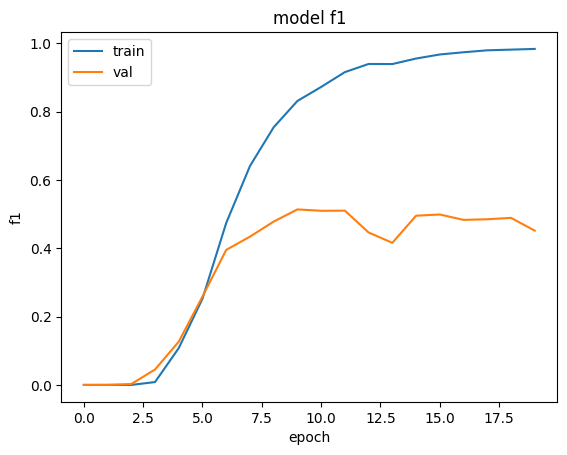

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **BIGRU и 2 LSTM**


In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
rnn_1 = tf.keras.layers.LSTM(128, return_sequences=True)(gru)
rnn_2 = tf.keras.layers.LSTM(128, return_sequences=False)(rnn_1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 100)          2409300   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 256)         176640    
 l)                                                              
                                                                 
 lstm (LSTM)                 (None, 200, 128)          197120    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 19)                2451      
                                                             

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 585s 13s/step - loss: 2.4240 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3137 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 573s 13s/step - loss: 2.1260 - f1: 0.0000e+00 - rec@prec: 1.1866e-04 - val_loss: 1.9289 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/20
43/43 [==============================] - 563s 13s/step - loss: 1.7773 - f1: 0.1479 - rec@prec: 0.0643 - val_loss: 1.7294 - val_f1: 0.2326 - val_rec@prec: 0.1483
Epoch 4/20
43/43 [==============================] - 547s 13s/step - loss: 1.6211 - f1: 0.3051 - rec@prec: 0.1506 - val_loss: 1.6545 - val_f1: 0.3192 - val_rec@prec: 0.1943
Epoch 5/20
43/43 [==============================] - 622s 14s/step - loss: 1.4154 - f1: 0.4638 - rec@prec: 0.2555 - val_loss: 1.4872 - val_f1: 0.5100 - val_rec@prec: 0.2696
Epoch 6/20
43/43 [==============================] - 609s 14s/step - loss: 1.2127 - f1: 0.5937 - rec@prec: 0.

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


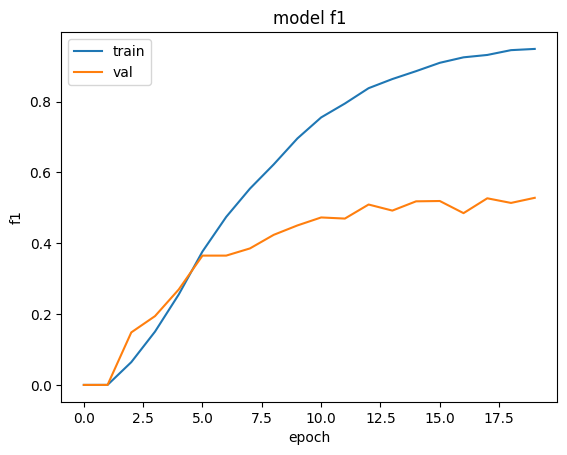

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **5 GRU и 3 LSTM**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

layer_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
layer_2 = tf.keras.layers.GRU(128, return_sequences=True)(layer_1)
layer_3 = tf.keras.layers.GRU(128, return_sequences=True)(layer_2)
layer_4 = tf.keras.layers.GRU(128, return_sequences=True)(layer_3)
layer_5 = tf.keras.layers.GRU(128, return_sequences=True)(layer_4)
layer_6 = tf.keras.layers.LSTM(128, return_sequences=True)(layer_5)
layer_7 = tf.keras.layers.LSTM(128, return_sequences=True)(layer_6)
layer_8 = tf.keras.layers.LSTM(128, return_sequences=False)(layer_7)

dense = tf.keras.layers.Dense(64, activation='relu')(layer_8)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 30)           722790    
                                                                 
 gru (GRU)                   (None, 200, 128)          61440     
                                                                 
 gru_1 (GRU)                 (None, 200, 128)          99072     
                                                                 
 gru_2 (GRU)                 (None, 200, 128)          99072     
                                                                 
 gru_3 (GRU)                 (None, 200, 128)          99072     
                                                                 
 gru_4 (GRU)                 (None, 200, 128)          99072 

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=500,
         epochs=20)

Epoch 1/20
85/85 [==============================] - 837s 10s/step - loss: 2.3265 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3217 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
85/85 [==============================] - 825s 10s/step - loss: 2.3240 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3209 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/20
85/85 [==============================] - 828s 10s/step - loss: 2.3230 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3226 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/20
85/85 [==============================] - 825s 10s/step - loss: 2.3243 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3227 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/20
85/85 [==============================] - 821s 10s/step - loss: 2.3237 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3238 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 6/20
85/85 [==============================] - 820s 10s

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


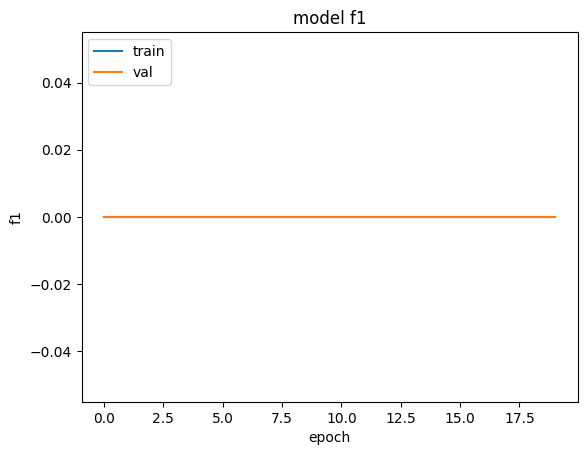

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **1 BIGRU и 1 BILSTM**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
rnn_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False))(gru)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn_1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 200, 100)          2409300   
                                                                 
 bidirectional_5 (Bidirectio  (None, 200, 256)         176640    
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 19)                4883      
                                                                 
Total params: 2,985,063
Trainable params: 2,985,063
Non-tra

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 497s 11s/step - loss: 2.4162 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2731 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 480s 11s/step - loss: 1.9590 - f1: 0.1306 - rec@prec: 0.0491 - val_loss: 1.7551 - val_f1: 0.2891 - val_rec@prec: 0.1163
Epoch 3/20
43/43 [==============================] - 485s 11s/step - loss: 1.4095 - f1: 0.5112 - rec@prec: 0.3171 - val_loss: 1.4333 - val_f1: 0.5285 - val_rec@prec: 0.3079
Epoch 4/20
43/43 [==============================] - 484s 11s/step - loss: 1.1055 - f1: 0.6571 - rec@prec: 0.5500 - val_loss: 1.2120 - val_f1: 0.6381 - val_rec@prec: 0.4838
Epoch 5/20
43/43 [==============================] - 483s 11s/step - loss: 0.9179 - f1: 0.7198 - rec@prec: 0.6668 - val_loss: 1.1509 - val_f1: 0.6551 - val_rec@prec: 0.5221
Epoch 6/20
43/43 [==============================] - 486s 11s/step - loss: 0.8186 - f1: 0.7552 - rec@prec: 0.7350 - val_loss:

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


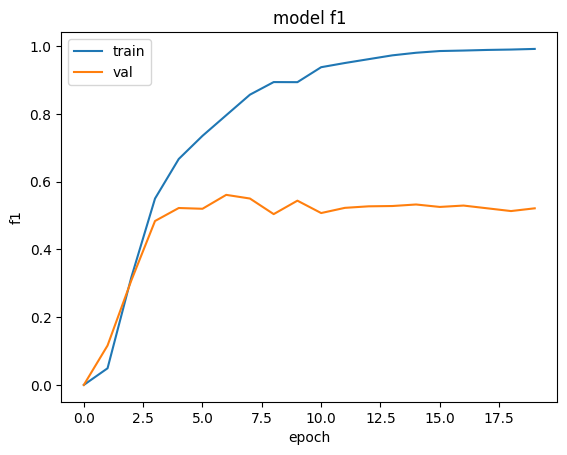

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **LSTM, GRU, BILSTM, BIGRU, GRU, LSTM**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
gru1 = tf.keras.layers.GRU(128, return_sequences=True)(lstm1)
bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(gru1)
bigru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bilstm)
gru2 = tf.keras.layers.GRU(128, return_sequences=True)(bigru)
lstm2 = tf.keras.layers.LSTM(128, return_sequences=False)(gru2)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 30)           722790    
                                                                 
 lstm_3 (LSTM)               (None, 200, 128)          81408     
                                                                 
 gru_5 (GRU)                 (None, 200, 128)          99072     
                                                                 
 bidirectional (Bidirectiona  (None, 200, 256)         263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 256)         296448    
 nal)                                                      

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=500,
         epochs=20)

Epoch 1/20
85/85 [==============================] - 964s 11s/step - loss: 2.3527 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.0916 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
85/85 [==============================] - 965s 11s/step - loss: 1.8977 - f1: 0.0221 - rec@prec: 0.0048 - val_loss: 1.7824 - val_f1: 0.1174 - val_rec@prec: 0.0676
Epoch 3/20
85/85 [==============================] - 963s 11s/step - loss: 1.6723 - f1: 0.1373 - rec@prec: 0.0821 - val_loss: 1.6915 - val_f1: 0.1544 - val_rec@prec: 0.0897
Epoch 4/20
85/85 [==============================] - 956s 11s/step - loss: 1.5602 - f1: 0.2019 - rec@prec: 0.1086 - val_loss: 1.6210 - val_f1: 0.2003 - val_rec@prec: 0.1105
Epoch 5/20
85/85 [==============================] - 950s 11s/step - loss: 1.4570 - f1: 0.2428 - rec@prec: 0.1279 - val_loss: 1.6378 - val_f1: 0.2014 - val_rec@prec: 0.1091
Epoch 6/20
85/85 [==============================] - 950s 11s/step - loss: 1.2654 - f1: 0.4248 - rec@prec: 0.2339 - val_loss:

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


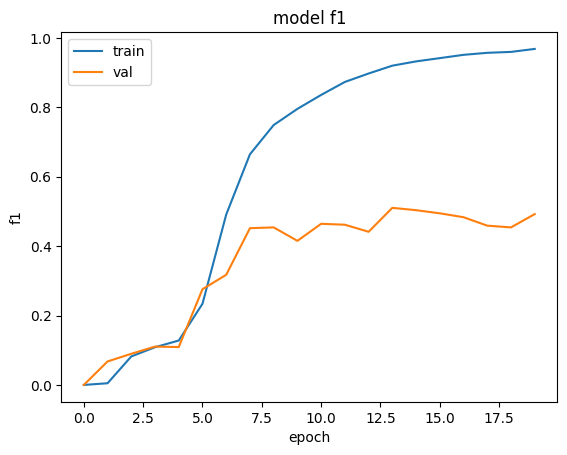

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **Вывод**

Сравнив графики, приходим к выводу, что лучше всего работает LSTM.  В остальном графики показывают похожее качество (примерно 0.5 по метрике f1). 

Следует упомянуть, что модели со слоями "5GRU, 3LSTM" и "LSTM, GRU, BILSTM, BIGRU, GRU, LSTM" отличаюся размером батчей (иначе код не запускается). Поэтому получается не очень объективно: по графику кажется, что"5GRU, 3LSTM" не обучается совсем. Но скорее всего увеличение количества батчей положительно повлияет на качество работы модели.  

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев. 
1) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев. 

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.7 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from sklearn.metrics import classification_report
import re

In [ ]:
dataset = load_dataset("wikiann", 'ru')

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/ru/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [ ]:
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)
     

id2word = {i:word for word, i in word2id.items()}

In [ ]:
X_train = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_train.append(ids)

In [ ]:
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [ ]:
MAX_LEN = max(len(x) for x in X_train)

In [ ]:
MAX_LEN

54

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [ ]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()}

In [ ]:
y_train = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [ ]:
y_train.shape, y_test.shape

((20000, 54), (10000, 54))

#**1) несколько слоёв BILSTM**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)
lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(lstm_1)
lstm_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(lstm_2)
lstm_4 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(lstm_3)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_4)

model1 = tf.keras.Model(inputs=inputs, outputs=outputs)
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])
     

In [ ]:
model1.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

Epoch 1/5
157/157 [==============================] - 271s 2s/step - loss: 0.2266 - accuracy: 0.9333 - val_loss: 0.1530 - val_accuracy: 0.9506
Epoch 2/5
157/157 [==============================] - 255s 2s/step - loss: 0.1361 - accuracy: 0.9558 - val_loss: 0.1240 - val_accuracy: 0.9585
Epoch 3/5
157/157 [==============================] - 246s 2s/step - loss: 0.1084 - accuracy: 0.9640 - val_loss: 0.1073 - val_accuracy: 0.9658
Epoch 4/5
157/157 [==============================] - 246s 2s/step - loss: 0.0740 - accuracy: 0.9759 - val_loss: 0.0832 - val_accuracy: 0.9739
Epoch 5/5
157/157 [==============================] - 246s 2s/step - loss: 0.0445 - accuracy: 0.9852 - val_loss: 0.0736 - val_accuracy: 0.9763


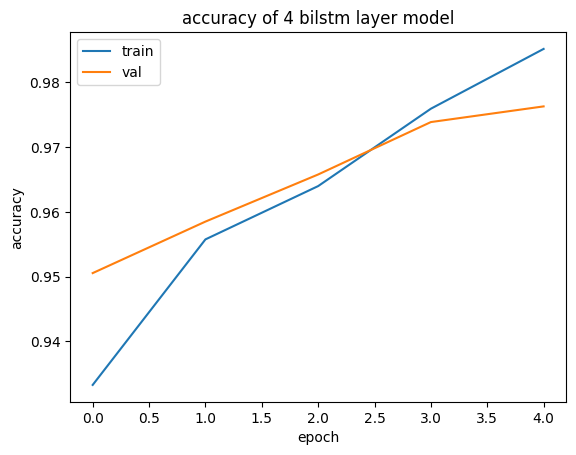

In [ ]:
plt.plot(model1.history.history['accuracy'])
plt.plot(model1.history.history['val_accuracy'])
plt.title('accuracy of 4 bilstm layer model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_preds = model1.predict(X_test).argmax(2)

313/313 [==============================] - 55s 168ms/step


In [ ]:
print(classification_report(y_test.reshape(-1), y_preds.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.90      0.93      0.92     40480
       B-PER       0.91      0.64      0.75      3542
       I-PER       0.93      0.70      0.80      7544
       B-ORG       0.53      0.60      0.56      4074
       I-ORG       0.60      0.79      0.68      8008
       B-LOC       0.78      0.47      0.59      4560
       I-LOC       0.69      0.76      0.72      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.79      0.74      0.75    540000
weighted avg       0.98      0.98      0.98    540000



# **2) несколько слоёв BIGRU**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

bigru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
bigru_2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru_1)
bigru_3 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru_2)
bigru_4 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru_3)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(bigru_4)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [ ]:
model2.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

Epoch 1/5
157/157 [==============================] - 222s 1s/step - loss: 0.2200 - accuracy: 0.9410 - val_loss: 0.1102 - val_accuracy: 0.9632
Epoch 2/5
157/157 [==============================] - 188s 1s/step - loss: 0.0649 - accuracy: 0.9789 - val_loss: 0.0497 - val_accuracy: 0.9839
Epoch 3/5
157/157 [==============================] - 206s 1s/step - loss: 0.0190 - accuracy: 0.9942 - val_loss: 0.0535 - val_accuracy: 0.9832
Epoch 4/5
157/157 [==============================] - 205s 1s/step - loss: 0.0084 - accuracy: 0.9977 - val_loss: 0.0519 - val_accuracy: 0.9853
Epoch 5/5
157/157 [==============================] - 205s 1s/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.0648 - val_accuracy: 0.9833


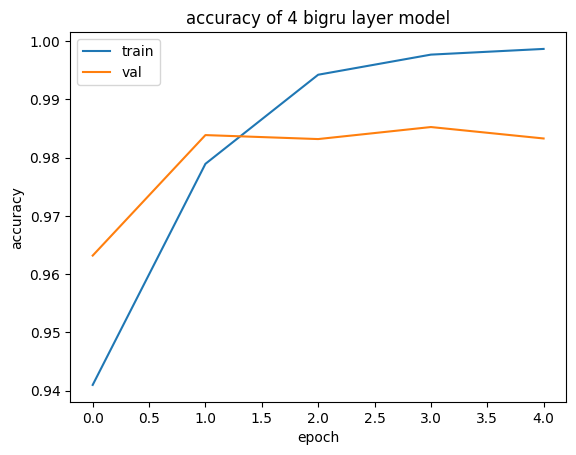

In [ ]:
plt.plot(model2.history.history['accuracy'])
plt.plot(model2.history.history['val_accuracy'])
plt.title('accuracy of 4 bigru layer model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_preds2 = model2.predict(X_test).argmax(2)

313/313 [==============================] - 38s 116ms/step


In [ ]:
print(classification_report(y_test.reshape(-1), y_preds2.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.97      0.90      0.93     40480
       B-PER       0.89      0.87      0.88      3542
       I-PER       0.89      0.93      0.91      7544
       B-ORG       0.62      0.75      0.68      4074
       I-ORG       0.73      0.83      0.78      8008
       B-LOC       0.67      0.82      0.73      4560
       I-LOC       0.82      0.76      0.79      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.82      0.86      0.84    540000
weighted avg       0.98      0.98      0.98    540000



# **Предсказания**

In [ ]:
def tokenize(text, word2id):
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):

    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

Попробуем предсказать именованные сущности, как в семинаре.

In [ ]:
label_seq('Корабль "Надежда" пришёл в питерскую гавань сегодня утром', word2id, id2labels, MAX_LEN, model1)

1/1 [==============================] - 0s 49ms/step


[('Корабль', 'O'),
 ('"', 'O'),
 ('Надежда', 'I-ORG'),
 ('"', 'I-ORG'),
 ('пришёл', 'O'),
 ('в', 'O'),
 ('питерскую', 'B-ORG'),
 ('гавань', 'I-ORG'),
 ('сегодня', 'I-ORG'),
 ('утром', 'O')]

In [ ]:
label_seq('Корабль "Надежда" пришёл в питерскую гавань сегодня утром', word2id, id2labels, MAX_LEN, model2)

1/1 [==============================] - 0s 38ms/step


[('Корабль', 'O'),
 ('"', 'B-ORG'),
 ('Надежда', 'I-ORG'),
 ('"', 'I-ORG'),
 ('пришёл', 'O'),
 ('в', 'O'),
 ('питерскую', 'B-ORG'),
 ('гавань', 'I-ORG'),
 ('сегодня', 'I-ORG'),
 ('утром', 'I-ORG')]

Тут работа моделей не очень хороша и почти идентична. Многие слова обозначены как не сущности, остальные - организации. 

In [ ]:
label_seq('Карандаш и Самоделкин едут в Париж', word2id, id2labels, MAX_LEN, model1)

1/1 [==============================] - 0s 34ms/step


[('Карандаш', 'O'),
 ('и', 'O'),
 ('Самоделкин', 'O'),
 ('едут', 'O'),
 ('в', 'B-ORG'),
 ('Париж', 'O')]

In [ ]:
label_seq('Карандаш и Самоделкин едут в Париж', word2id, id2labels, MAX_LEN, model2)

1/1 [==============================] - 0s 32ms/step


[('Карандаш', 'B-LOC'),
 ('и', 'O'),
 ('Самоделкин', 'B-LOC'),
 ('едут', 'I-ORG'),
 ('в', 'O'),
 ('Париж', 'B-LOC')]

BILSTM не видит именованных сущностей. 

Но для BIGRU Карандаш и Самоделкин оказались местами! Зато верно, как место, определён и Париж.

In [ ]:
label_seq('Иван Васильевич едет купаться в Онтарио на своём Бентли', word2id, id2labels, MAX_LEN, model1)

1/1 [==============================] - 0s 54ms/step


[('Иван', 'B-ORG'),
 ('Васильевич', 'I-ORG'),
 ('едет', 'O'),
 ('купаться', 'O'),
 ('в', 'O'),
 ('Онтарио', 'O'),
 ('на', 'O'),
 ('своём', 'I-ORG'),
 ('Бентли', 'O')]

In [ ]:
label_seq('Иван Васильевич едет купаться в Онтарио на своём Бентли', word2id, id2labels, MAX_LEN, model2)

1/1 [==============================] - 0s 34ms/step


[('Иван', 'B-ORG'),
 ('Васильевич', 'I-PER'),
 ('едет', 'I-LOC'),
 ('купаться', 'I-LOC'),
 ('в', 'O'),
 ('Онтарио', 'B-LOC'),
 ('на', 'O'),
 ('своём', 'O'),
 ('Бентли', 'O')]

BILSTM определяет "Иван" и "Васильевич" как B-ORG, "Онтарио" и "Бентли" - просто О.

Для BIGRU "Васильевич" - уже PER (в отличие от "Ивана"), Онтарио - место. Бентли как именованную сущность распознать не удалось.

In [ ]:
label_seq('Надя, Катя, маша, Юра, сергей витальевич, Валентин, Шариков, шариков, Петров', word2id, id2labels, MAX_LEN, model1)

1/1 [==============================] - 0s 38ms/step


[('Надя', 'B-ORG'),
 (',', 'I-ORG'),
 ('Катя', 'I-ORG'),
 (',', 'I-ORG'),
 ('маша', 'I-ORG'),
 (',', 'I-ORG'),
 ('Юра', 'I-ORG'),
 (',', 'I-ORG'),
 ('сергей', 'I-ORG'),
 ('витальевич', 'I-PER'),
 (',', 'I-PER'),
 ('Валентин', 'I-PER'),
 (',', 'O'),
 ('Шариков', 'O'),
 (',', 'O'),
 ('шариков', 'O'),
 (',', 'O'),
 ('Петров', 'O')]

In [ ]:
label_seq('Надя, Катя, маша, Юра, сергей витальевич, Валентин, Шариков, шариков, Петров', word2id, id2labels, MAX_LEN, model2)

1/1 [==============================] - 0s 36ms/step


[('Надя', 'B-PER'),
 (',', 'O'),
 ('Катя', 'B-LOC'),
 (',', 'O'),
 ('маша', 'B-PER'),
 (',', 'O'),
 ('Юра', 'B-LOC'),
 (',', 'O'),
 ('сергей', 'B-PER'),
 ('витальевич', 'I-PER'),
 (',', 'O'),
 ('Валентин', 'B-PER'),
 (',', 'O'),
 ('Шариков', 'O'),
 (',', 'O'),
 ('шариков', 'O'),
 (',', 'O'),
 ('Петров', 'B-LOC')]

BILSTM определяет как имена только "Валентин", "Витальевич" и запятую, остальные же имена получают теги O или I-ORG, причём нет корелляции с тем, написаны они с большой или маленькой буквы. При этом, можно подумать, что "шариков" и "Шариков" - не фамилия персонажа Булгакова, а просто слово "шарик" в мн.ч., р.п.. Поэтому оно не определилось как именованная сущность и с помощью BIGRU. В остальном, вторая модель работает действительно лучше: несмотря на то, что Катя, Юра и Петров (есть ли такой город? может, что-то вроде "град Петров"?) оказались местами, запятые в именованные сущности не попали, и все остальные имена были определены верно.

# **Вывод:**

Качество работы моделей оставляет желать лучшего. Удивительным образом, лучше всего именованная сущность определяется, если это отчество. С фамилиями персонажей и с обыкновеннвми именами дело обстоит чуть хуже. 
Притом, BIGRU в целом справляется с задачей лучше, чем BILSTM. 